In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

C:\Users\21550\anaconda3\envs\pytorch_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset=CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)


In [7]:
# 获取一个 batch
images, labels = next(iter(train_loader))

# 查看最小值和最大值
print("Min value:", images.min().item())
print("Max value:", images.max().item())

Min value: -1.0
Max value: 1.0


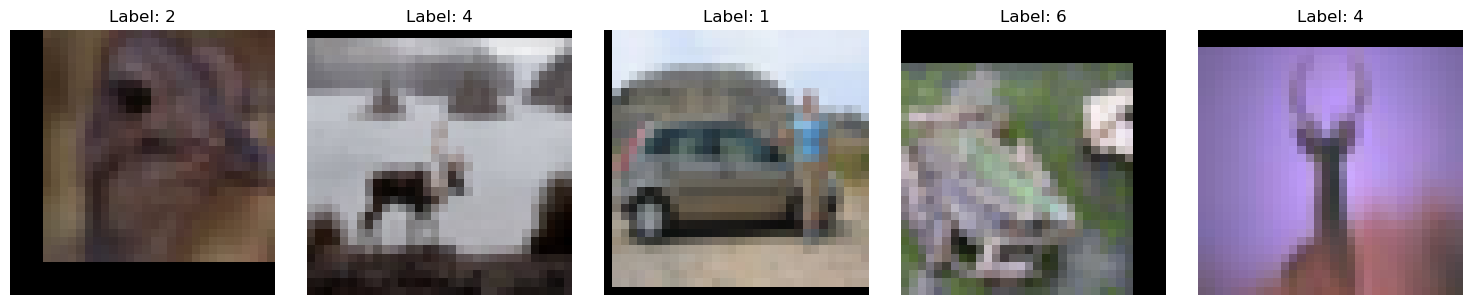

In [8]:
import matplotlib.pyplot as plt
import torchvision

# 如果你使用了 Normalize，需要定义逆变换
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# 获取一个 batch
images, labels = next(iter(train_loader))

# 只看前5张
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = inv_normalize(images[i]).clamp(0, 1)  # 逆归一化并裁剪
    img = img.permute(1, 2, 0).cpu().numpy()    # CHW -> HWC
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [9]:
print(len(train_dataset), len(dev_dataset))

45000 5000


In [10]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [16]:
class ResNetSmallWide(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 3→128
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Stage 1
            Residual(32, 32),
            Residual(32, 32),

            # Stage 2
            Residual(32, 64, use_1x1conv=True, strides=2),
            Residual(64, 64),

            # Stage 3
            Residual(64, 128, use_1x1conv=True, strides=2),
            Residual(128, 128),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)  # 末尾全连接也需对应修改
        )

    def forward(self, x):
        return self.net(x)

In [20]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmallWide().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.0001)

In [21]:
print(device)

cuda


In [22]:
from tqdm import tqdm
train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 验证阶段
    model.eval()
    dev_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            dev_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_loss /= total
    dev_acc = correct / total
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {dev_loss:.4f}, Acc: {dev_acc:.4f}")

    if dev_acc > best_acc:
        best_acc = dev_acc
        torch.save(model.state_dict(), 'best_model_light.pth')

Epoch 1/100: 100%|██████████| 352/352 [00:25<00:00, 13.77it/s]


Epoch 1 => Train Loss: 1.4057, Acc: 0.4839 | Val Loss: 1.1699, Acc: 0.5904


Epoch 2/100: 100%|██████████| 352/352 [00:25<00:00, 13.62it/s]


Epoch 2 => Train Loss: 0.9522, Acc: 0.6584 | Val Loss: 0.8255, Acc: 0.7046


Epoch 3/100: 100%|██████████| 352/352 [00:51<00:00,  6.82it/s]


Epoch 3 => Train Loss: 0.7752, Acc: 0.7281 | Val Loss: 0.9703, Acc: 0.6744


Epoch 4/100: 100%|██████████| 352/352 [00:56<00:00,  6.21it/s]


Epoch 4 => Train Loss: 0.6621, Acc: 0.7679 | Val Loss: 0.7932, Acc: 0.7306


Epoch 5/100: 100%|██████████| 352/352 [00:55<00:00,  6.32it/s]


Epoch 5 => Train Loss: 0.5854, Acc: 0.7974 | Val Loss: 0.6706, Acc: 0.7780


Epoch 6/100: 100%|██████████| 352/352 [00:56<00:00,  6.23it/s]


Epoch 6 => Train Loss: 0.5254, Acc: 0.8194 | Val Loss: 0.6053, Acc: 0.7980


Epoch 7/100: 100%|██████████| 352/352 [00:44<00:00,  7.98it/s]


Epoch 7 => Train Loss: 0.4844, Acc: 0.8336 | Val Loss: 0.5296, Acc: 0.8212


Epoch 8/100: 100%|██████████| 352/352 [00:26<00:00, 13.48it/s]


Epoch 8 => Train Loss: 0.4492, Acc: 0.8454 | Val Loss: 0.5910, Acc: 0.7988


Epoch 9/100: 100%|██████████| 352/352 [00:26<00:00, 13.31it/s]


Epoch 9 => Train Loss: 0.4168, Acc: 0.8562 | Val Loss: 0.4507, Acc: 0.8484


Epoch 10/100: 100%|██████████| 352/352 [00:25<00:00, 13.61it/s]


Epoch 10 => Train Loss: 0.3941, Acc: 0.8630 | Val Loss: 0.4623, Acc: 0.8480


Epoch 11/100: 100%|██████████| 352/352 [00:25<00:00, 13.57it/s]


Epoch 11 => Train Loss: 0.3681, Acc: 0.8729 | Val Loss: 0.4676, Acc: 0.8464


Epoch 12/100: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s]


Epoch 12 => Train Loss: 0.3456, Acc: 0.8802 | Val Loss: 0.5132, Acc: 0.8344


Epoch 13/100: 100%|██████████| 352/352 [00:25<00:00, 13.70it/s]


Epoch 13 => Train Loss: 0.3270, Acc: 0.8867 | Val Loss: 0.4672, Acc: 0.8490


Epoch 14/100: 100%|██████████| 352/352 [00:25<00:00, 13.67it/s]


Epoch 14 => Train Loss: 0.3130, Acc: 0.8900 | Val Loss: 0.4768, Acc: 0.8426


Epoch 15/100: 100%|██████████| 352/352 [00:26<00:00, 13.34it/s]


Epoch 15 => Train Loss: 0.2973, Acc: 0.8964 | Val Loss: 0.5782, Acc: 0.8282


Epoch 16/100: 100%|██████████| 352/352 [00:26<00:00, 13.48it/s]


Epoch 16 => Train Loss: 0.2812, Acc: 0.9024 | Val Loss: 0.4393, Acc: 0.8626


Epoch 17/100: 100%|██████████| 352/352 [00:26<00:00, 13.49it/s]


Epoch 17 => Train Loss: 0.2629, Acc: 0.9088 | Val Loss: 0.3771, Acc: 0.8812


Epoch 18/100: 100%|██████████| 352/352 [00:30<00:00, 11.46it/s]


Epoch 18 => Train Loss: 0.2551, Acc: 0.9106 | Val Loss: 0.3956, Acc: 0.8696


Epoch 19/100: 100%|██████████| 352/352 [00:56<00:00,  6.22it/s]


Epoch 19 => Train Loss: 0.2465, Acc: 0.9141 | Val Loss: 0.4828, Acc: 0.8516


Epoch 20/100: 100%|██████████| 352/352 [00:58<00:00,  6.07it/s]


Epoch 20 => Train Loss: 0.2351, Acc: 0.9181 | Val Loss: 0.3768, Acc: 0.8812


Epoch 21/100: 100%|██████████| 352/352 [00:56<00:00,  6.18it/s]


Epoch 21 => Train Loss: 0.2221, Acc: 0.9224 | Val Loss: 0.3842, Acc: 0.8770


Epoch 22/100: 100%|██████████| 352/352 [00:57<00:00,  6.15it/s]


Epoch 22 => Train Loss: 0.2112, Acc: 0.9251 | Val Loss: 0.3901, Acc: 0.8770


Epoch 23/100: 100%|██████████| 352/352 [00:57<00:00,  6.15it/s]


Epoch 23 => Train Loss: 0.2036, Acc: 0.9291 | Val Loss: 0.3966, Acc: 0.8740


Epoch 24/100: 100%|██████████| 352/352 [00:55<00:00,  6.31it/s]


Epoch 24 => Train Loss: 0.1970, Acc: 0.9311 | Val Loss: 0.3860, Acc: 0.8818


Epoch 25/100: 100%|██████████| 352/352 [00:33<00:00, 10.47it/s]


Epoch 25 => Train Loss: 0.1885, Acc: 0.9336 | Val Loss: 0.3896, Acc: 0.8822


Epoch 26/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 26 => Train Loss: 0.1776, Acc: 0.9372 | Val Loss: 0.3993, Acc: 0.8864


Epoch 27/100: 100%|██████████| 352/352 [00:57<00:00,  6.08it/s]


Epoch 27 => Train Loss: 0.1672, Acc: 0.9406 | Val Loss: 0.4310, Acc: 0.8762


Epoch 28/100: 100%|██████████| 352/352 [00:47<00:00,  7.38it/s]


Epoch 28 => Train Loss: 0.1685, Acc: 0.9398 | Val Loss: 0.3926, Acc: 0.8918


Epoch 29/100: 100%|██████████| 352/352 [00:52<00:00,  6.69it/s]


Epoch 29 => Train Loss: 0.1563, Acc: 0.9440 | Val Loss: 0.4359, Acc: 0.8774


Epoch 30/100: 100%|██████████| 352/352 [00:52<00:00,  6.66it/s]


Epoch 30 => Train Loss: 0.1531, Acc: 0.9451 | Val Loss: 0.3904, Acc: 0.8898


Epoch 31/100: 100%|██████████| 352/352 [00:25<00:00, 13.82it/s]


Epoch 31 => Train Loss: 0.1470, Acc: 0.9474 | Val Loss: 0.3576, Acc: 0.8934


Epoch 32/100: 100%|██████████| 352/352 [00:25<00:00, 13.83it/s]


Epoch 32 => Train Loss: 0.1459, Acc: 0.9483 | Val Loss: 0.3720, Acc: 0.8952


Epoch 33/100: 100%|██████████| 352/352 [00:40<00:00,  8.71it/s]


Epoch 33 => Train Loss: 0.1387, Acc: 0.9509 | Val Loss: 0.4244, Acc: 0.8868


Epoch 34/100: 100%|██████████| 352/352 [00:43<00:00,  8.00it/s]


Epoch 34 => Train Loss: 0.1288, Acc: 0.9534 | Val Loss: 0.4466, Acc: 0.8826


Epoch 35/100: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s]


Epoch 35 => Train Loss: 0.1265, Acc: 0.9549 | Val Loss: 0.3788, Acc: 0.8938


Epoch 36/100: 100%|██████████| 352/352 [00:26<00:00, 13.46it/s]


Epoch 36 => Train Loss: 0.1242, Acc: 0.9553 | Val Loss: 0.3945, Acc: 0.8946


Epoch 37/100: 100%|██████████| 352/352 [00:49<00:00,  7.06it/s]


Epoch 37 => Train Loss: 0.1198, Acc: 0.9573 | Val Loss: 0.4142, Acc: 0.8892


Epoch 38/100: 100%|██████████| 352/352 [00:54<00:00,  6.46it/s]


Epoch 38 => Train Loss: 0.1186, Acc: 0.9575 | Val Loss: 0.4185, Acc: 0.8880


Epoch 39/100: 100%|██████████| 352/352 [00:44<00:00,  7.99it/s]


Epoch 39 => Train Loss: 0.1118, Acc: 0.9601 | Val Loss: 0.4155, Acc: 0.8882


Epoch 40/100: 100%|██████████| 352/352 [00:57<00:00,  6.11it/s]


Epoch 40 => Train Loss: 0.1103, Acc: 0.9607 | Val Loss: 0.4222, Acc: 0.8892


Epoch 41/100: 100%|██████████| 352/352 [00:56<00:00,  6.24it/s]


Epoch 41 => Train Loss: 0.1084, Acc: 0.9614 | Val Loss: 0.4148, Acc: 0.8906


Epoch 42/100: 100%|██████████| 352/352 [00:57<00:00,  6.10it/s]


Epoch 42 => Train Loss: 0.1022, Acc: 0.9635 | Val Loss: 0.4134, Acc: 0.8956


Epoch 43/100: 100%|██████████| 352/352 [00:57<00:00,  6.08it/s]


Epoch 43 => Train Loss: 0.1013, Acc: 0.9646 | Val Loss: 0.4003, Acc: 0.8962


Epoch 44/100: 100%|██████████| 352/352 [00:55<00:00,  6.37it/s]


Epoch 44 => Train Loss: 0.0990, Acc: 0.9653 | Val Loss: 0.4637, Acc: 0.8862


Epoch 45/100: 100%|██████████| 352/352 [00:54<00:00,  6.43it/s]


Epoch 45 => Train Loss: 0.0918, Acc: 0.9673 | Val Loss: 0.3939, Acc: 0.9030


Epoch 46/100: 100%|██████████| 352/352 [00:55<00:00,  6.40it/s]


Epoch 46 => Train Loss: 0.0922, Acc: 0.9668 | Val Loss: 0.4748, Acc: 0.8854


Epoch 47/100: 100%|██████████| 352/352 [00:56<00:00,  6.26it/s]


Epoch 47 => Train Loss: 0.0894, Acc: 0.9672 | Val Loss: 0.4180, Acc: 0.8930


Epoch 48/100: 100%|██████████| 352/352 [00:55<00:00,  6.38it/s]


Epoch 48 => Train Loss: 0.0872, Acc: 0.9697 | Val Loss: 0.4448, Acc: 0.9012


Epoch 49/100: 100%|██████████| 352/352 [00:55<00:00,  6.33it/s]


Epoch 49 => Train Loss: 0.0911, Acc: 0.9683 | Val Loss: 0.4052, Acc: 0.8978


Epoch 50/100: 100%|██████████| 352/352 [00:46<00:00,  7.63it/s]


Epoch 50 => Train Loss: 0.0806, Acc: 0.9708 | Val Loss: 0.4624, Acc: 0.8896


Epoch 51/100: 100%|██████████| 352/352 [00:25<00:00, 13.78it/s]


Epoch 51 => Train Loss: 0.0836, Acc: 0.9705 | Val Loss: 0.4170, Acc: 0.9000


Epoch 52/100: 100%|██████████| 352/352 [00:25<00:00, 13.78it/s]


Epoch 52 => Train Loss: 0.0799, Acc: 0.9707 | Val Loss: 0.4486, Acc: 0.9024


Epoch 53/100: 100%|██████████| 352/352 [00:25<00:00, 13.86it/s]


Epoch 53 => Train Loss: 0.0785, Acc: 0.9715 | Val Loss: 0.5131, Acc: 0.8846


Epoch 54/100: 100%|██████████| 352/352 [00:25<00:00, 13.80it/s]


Epoch 54 => Train Loss: 0.0786, Acc: 0.9718 | Val Loss: 0.4099, Acc: 0.9076


Epoch 55/100: 100%|██████████| 352/352 [00:25<00:00, 13.93it/s]


Epoch 55 => Train Loss: 0.0732, Acc: 0.9737 | Val Loss: 0.4278, Acc: 0.9014


Epoch 56/100: 100%|██████████| 352/352 [00:25<00:00, 13.89it/s]


Epoch 56 => Train Loss: 0.0743, Acc: 0.9736 | Val Loss: 0.4121, Acc: 0.9058


Epoch 57/100: 100%|██████████| 352/352 [00:34<00:00, 10.17it/s]


Epoch 57 => Train Loss: 0.0776, Acc: 0.9730 | Val Loss: 0.4673, Acc: 0.8918


Epoch 58/100: 100%|██████████| 352/352 [00:59<00:00,  5.92it/s]


Epoch 58 => Train Loss: 0.0683, Acc: 0.9761 | Val Loss: 0.4180, Acc: 0.9002


Epoch 59/100: 100%|██████████| 352/352 [00:55<00:00,  6.38it/s]


Epoch 59 => Train Loss: 0.0661, Acc: 0.9768 | Val Loss: 0.4427, Acc: 0.8952


Epoch 60/100: 100%|██████████| 352/352 [00:55<00:00,  6.34it/s]


Epoch 60 => Train Loss: 0.0714, Acc: 0.9750 | Val Loss: 0.4165, Acc: 0.9034


Epoch 61/100: 100%|██████████| 352/352 [00:55<00:00,  6.35it/s]


Epoch 61 => Train Loss: 0.0683, Acc: 0.9759 | Val Loss: 0.4472, Acc: 0.9002


Epoch 62/100: 100%|██████████| 352/352 [00:55<00:00,  6.29it/s]


Epoch 62 => Train Loss: 0.0665, Acc: 0.9768 | Val Loss: 0.4751, Acc: 0.8960


Epoch 63/100: 100%|██████████| 352/352 [00:55<00:00,  6.31it/s]


Epoch 63 => Train Loss: 0.0649, Acc: 0.9769 | Val Loss: 0.4919, Acc: 0.8968


Epoch 64/100: 100%|██████████| 352/352 [00:56<00:00,  6.27it/s]


Epoch 64 => Train Loss: 0.0628, Acc: 0.9775 | Val Loss: 0.4501, Acc: 0.9034


Epoch 65/100: 100%|██████████| 352/352 [00:55<00:00,  6.36it/s]


Epoch 65 => Train Loss: 0.0647, Acc: 0.9770 | Val Loss: 0.4671, Acc: 0.9012


Epoch 66/100: 100%|██████████| 352/352 [00:55<00:00,  6.36it/s]


Epoch 66 => Train Loss: 0.0654, Acc: 0.9770 | Val Loss: 0.4825, Acc: 0.8982


Epoch 67/100: 100%|██████████| 352/352 [00:44<00:00,  7.93it/s]


Epoch 67 => Train Loss: 0.0550, Acc: 0.9802 | Val Loss: 0.4776, Acc: 0.8964


Epoch 68/100: 100%|██████████| 352/352 [00:26<00:00, 13.48it/s]


Epoch 68 => Train Loss: 0.0598, Acc: 0.9783 | Val Loss: 0.5068, Acc: 0.8954


Epoch 69/100: 100%|██████████| 352/352 [00:52<00:00,  6.66it/s]


Epoch 69 => Train Loss: 0.0592, Acc: 0.9792 | Val Loss: 0.4486, Acc: 0.9058


Epoch 70/100: 100%|██████████| 352/352 [00:54<00:00,  6.40it/s]


Epoch 70 => Train Loss: 0.0598, Acc: 0.9788 | Val Loss: 0.4676, Acc: 0.8996


Epoch 71/100: 100%|██████████| 352/352 [00:54<00:00,  6.41it/s]


Epoch 71 => Train Loss: 0.0524, Acc: 0.9811 | Val Loss: 0.4369, Acc: 0.9078


Epoch 72/100: 100%|██████████| 352/352 [00:54<00:00,  6.43it/s]


Epoch 72 => Train Loss: 0.0583, Acc: 0.9791 | Val Loss: 0.4473, Acc: 0.9006


Epoch 73/100: 100%|██████████| 352/352 [00:54<00:00,  6.46it/s]


Epoch 73 => Train Loss: 0.0529, Acc: 0.9803 | Val Loss: 0.4590, Acc: 0.9056


Epoch 74/100: 100%|██████████| 352/352 [00:55<00:00,  6.31it/s]


Epoch 74 => Train Loss: 0.0501, Acc: 0.9819 | Val Loss: 0.4852, Acc: 0.9028


Epoch 75/100: 100%|██████████| 352/352 [00:55<00:00,  6.40it/s]


Epoch 75 => Train Loss: 0.0546, Acc: 0.9812 | Val Loss: 0.4711, Acc: 0.9040


Epoch 76/100: 100%|██████████| 352/352 [00:54<00:00,  6.43it/s]


Epoch 76 => Train Loss: 0.0513, Acc: 0.9813 | Val Loss: 0.4784, Acc: 0.9038


Epoch 77/100: 100%|██████████| 352/352 [00:55<00:00,  6.40it/s]


Epoch 77 => Train Loss: 0.0482, Acc: 0.9834 | Val Loss: 0.5196, Acc: 0.9018


Epoch 78/100: 100%|██████████| 352/352 [00:57<00:00,  6.13it/s]


Epoch 78 => Train Loss: 0.0527, Acc: 0.9811 | Val Loss: 0.5506, Acc: 0.8938


Epoch 79/100: 100%|██████████| 352/352 [00:57<00:00,  6.13it/s]


Epoch 79 => Train Loss: 0.0470, Acc: 0.9834 | Val Loss: 0.4889, Acc: 0.9024


Epoch 80/100: 100%|██████████| 352/352 [00:42<00:00,  8.22it/s]


Epoch 80 => Train Loss: 0.0476, Acc: 0.9824 | Val Loss: 0.4825, Acc: 0.9012


Epoch 81/100: 100%|██████████| 352/352 [00:57<00:00,  6.15it/s]


Epoch 81 => Train Loss: 0.0493, Acc: 0.9825 | Val Loss: 0.4879, Acc: 0.9016


Epoch 82/100: 100%|██████████| 352/352 [00:58<00:00,  6.07it/s]


Epoch 82 => Train Loss: 0.0491, Acc: 0.9825 | Val Loss: 0.4840, Acc: 0.9024


Epoch 83/100: 100%|██████████| 352/352 [00:58<00:00,  6.00it/s]


Epoch 83 => Train Loss: 0.0488, Acc: 0.9824 | Val Loss: 0.5173, Acc: 0.8980


Epoch 84/100: 100%|██████████| 352/352 [00:59<00:00,  5.94it/s]


Epoch 84 => Train Loss: 0.0458, Acc: 0.9837 | Val Loss: 0.4824, Acc: 0.9036


Epoch 85/100: 100%|██████████| 352/352 [00:58<00:00,  6.03it/s]


Epoch 85 => Train Loss: 0.0460, Acc: 0.9836 | Val Loss: 0.4752, Acc: 0.9028


Epoch 86/100: 100%|██████████| 352/352 [00:56<00:00,  6.21it/s]


Epoch 86 => Train Loss: 0.0489, Acc: 0.9824 | Val Loss: 0.5240, Acc: 0.8970


Epoch 87/100: 100%|██████████| 352/352 [00:56<00:00,  6.24it/s]


Epoch 87 => Train Loss: 0.0426, Acc: 0.9852 | Val Loss: 0.4912, Acc: 0.9070


Epoch 88/100: 100%|██████████| 352/352 [00:37<00:00,  9.41it/s]


Epoch 88 => Train Loss: 0.0449, Acc: 0.9838 | Val Loss: 0.4692, Acc: 0.9118


Epoch 89/100: 100%|██████████| 352/352 [00:25<00:00, 13.84it/s]


Epoch 89 => Train Loss: 0.0417, Acc: 0.9851 | Val Loss: 0.5006, Acc: 0.9038


Epoch 90/100: 100%|██████████| 352/352 [00:25<00:00, 13.83it/s]


Epoch 90 => Train Loss: 0.0461, Acc: 0.9837 | Val Loss: 0.5218, Acc: 0.9022


Epoch 91/100: 100%|██████████| 352/352 [00:25<00:00, 13.86it/s]


Epoch 91 => Train Loss: 0.0449, Acc: 0.9842 | Val Loss: 0.4947, Acc: 0.9040


Epoch 92/100: 100%|██████████| 352/352 [00:25<00:00, 13.86it/s]


Epoch 92 => Train Loss: 0.0432, Acc: 0.9845 | Val Loss: 0.4888, Acc: 0.9032


Epoch 93/100: 100%|██████████| 352/352 [00:25<00:00, 13.88it/s]


Epoch 93 => Train Loss: 0.0428, Acc: 0.9847 | Val Loss: 0.4878, Acc: 0.9014


Epoch 94/100: 100%|██████████| 352/352 [00:25<00:00, 13.91it/s]


Epoch 94 => Train Loss: 0.0410, Acc: 0.9861 | Val Loss: 0.4802, Acc: 0.9054


Epoch 95/100: 100%|██████████| 352/352 [00:25<00:00, 13.93it/s]


Epoch 95 => Train Loss: 0.0403, Acc: 0.9861 | Val Loss: 0.5069, Acc: 0.9038


Epoch 96/100: 100%|██████████| 352/352 [00:25<00:00, 13.87it/s]


Epoch 96 => Train Loss: 0.0350, Acc: 0.9872 | Val Loss: 0.5724, Acc: 0.8916


Epoch 97/100: 100%|██████████| 352/352 [00:25<00:00, 13.83it/s]


Epoch 97 => Train Loss: 0.0396, Acc: 0.9861 | Val Loss: 0.5178, Acc: 0.9016


Epoch 98/100: 100%|██████████| 352/352 [00:25<00:00, 13.94it/s]


Epoch 98 => Train Loss: 0.0402, Acc: 0.9855 | Val Loss: 0.5060, Acc: 0.9040


Epoch 99/100: 100%|██████████| 352/352 [00:25<00:00, 14.03it/s]


Epoch 99 => Train Loss: 0.0399, Acc: 0.9856 | Val Loss: 0.5198, Acc: 0.9014


Epoch 100/100: 100%|██████████| 352/352 [00:25<00:00, 14.02it/s]


Epoch 100 => Train Loss: 0.0367, Acc: 0.9872 | Val Loss: 0.4990, Acc: 0.9028


In [23]:
import numpy as np

# 将4个列表转为 numpy 数组并堆叠为 (epochs, 4) 的二维数组
results = np.column_stack((train_losses, dev_losses, train_accuracies, dev_accuracies)) 

# 保存为 txt 文件，添加列名
np.savetxt("adamW_weight_light.txt", results, 
           header="Train_Loss Validation_Loss Train_Accuracy Validation_Accuracy", 
           fmt='%.6f', delimiter='\t')

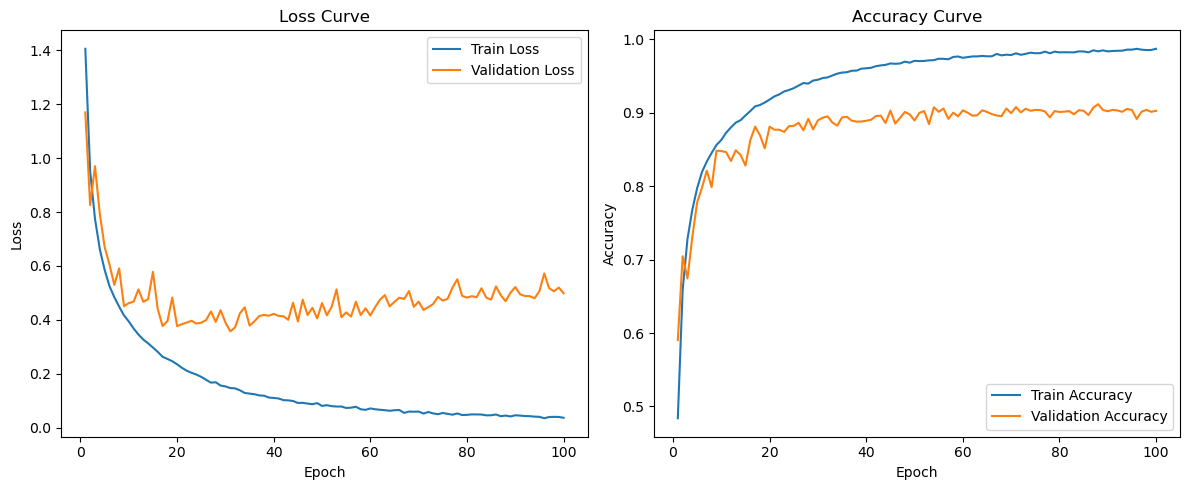

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, dev_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()


In [25]:
model.eval()  # 设置为评估模式
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

C:\Users\21550\anaconda3\envs\pytorch_3\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Test Accuracy: 90.11%


In [26]:
model2 = ResNetSmallWide(num_classes=10)
model2.load_state_dict(torch.load('best_model_light.pth'))
model2.to(device)
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 90.18%
